In [1]:
from keras import layers
from keras import models
from keras import applications
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report, confusion_matrix
from itertools import cycle
from tensorflow.python.client import device_lib
import itertools
from keras import backend as K
from keras.models import Model
from keras import optimizers
from keras.layers.normalization import BatchNormalization
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

print(device_lib.list_local_devices())
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13792827862886081697
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6671596257
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12702856263332183186
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:81:00.0, compute capability: 6.1"
]


['/job:localhost/replica:0/task:0/device:GPU:0']

In [2]:
def getTargetNames(validation_generator):
    dictionary = validation_generator.class_indices
    result = []
    result_indexes = []
    for x in dictionary:
        #print(x)
        result.append(x)
        result_indexes.append(dictionary[x])
    return result, result_indexes

In [4]:
#train_dir = "C:/Users/Canpolat/Documents/Uni/masterthesis/voter_Entwurf/Tomaten3/train"
#validation_dir = "C:/Users/Canpolat/Documents/Uni/masterthesis/voter_Entwurf/Tomaten3/validation"
#test_dir = "C:/Users/Canpolat/Documents/Uni/masterthesis/voter_Entwurf/Tomaten3/test"
train_dir = "C:/Users/Ilker/Desktop/Tomaten3/train"
validation_dir = "C:/Users/Ilker/Desktop/Tomaten3/validation"
test_dir = "C:/Users/Ilker/Desktop/Tomaten3/test"

# Rescales all images by 1/255
#rain_datagen = ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)
#validation_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(
    rescale=1./255
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)


train_generator = train_datagen.flow_from_directory(
    train_dir, # Target directory
    target_size=(150, 150), #Resizes all images to 150 × 150
    batch_size=32,
    class_mode='categorical') #Because you use binary_crossentropy loss, you need binary labels


validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

print(validation_generator.class_indices)
target_names, target_index = getTargetNames(validation_generator)

Found 3822 images belonging to 5 classes.
Found 1072 images belonging to 5 classes.
Found 538 images belonging to 5 classes.
{'Early_blight': 0, 'Late_blight': 1, 'Leaf_Mold': 2, 'Yellow_Leaf_Curl_Virus': 3, 'healthy': 4}


In [5]:
model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (150, 150, 3))

for layer in model.layers[:-1]:
    layer.trainable = False

x = model.output
x = layers.Flatten()(x)
x = layers.Dense(150)(x)
predictions = layers.Dense(5, activation="softmax")(x)
model = Model(input = model.input, output = predictions)

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
bloc

C:\Users\Ilker\Anaconda3\envs\masterarbeit\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys


In [6]:
model.compile(loss='categorical_crossentropy',
optimizer=optimizers.Adam(lr=1e-3),
metrics=['acc'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=35)
mc = ModelCheckpoint('C:/Users/Ilker/Desktop/transfer_learned.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=230,
    epochs=150,
    validation_data=validation_generator,
    validation_steps=43,
    callbacks = [es, mc])

Instructions for updating:
Use tf.cast instead.
Epoch 1/150
230/230 [==============================] - 71s 307ms/step - loss: 1.4757 - acc: 0.3825 - val_loss: 1.2500 - val_acc: 0.5434

Epoch 00001: val_loss improved from inf to 1.24998, saving model to C:/Users/Ilker/Desktop/transfer_learned.h5
Epoch 2/150
230/230 [==============================] - 61s 263ms/step - loss: 1.2327 - acc: 0.5427 - val_loss: 1.0889 - val_acc: 0.6051

Epoch 00002: val_loss improved from 1.24998 to 1.08893, saving model to C:/Users/Ilker/Desktop/transfer_learned.h5
Epoch 3/150
230/230 [==============================] - 61s 264ms/step - loss: 1.1135 - acc: 0.5940 - val_loss: 0.9247 - val_acc: 0.6801

Epoch 00003: val_loss improved from 1.08893 to 0.92473, saving model to C:/Users/Ilker/Desktop/transfer_learned.h5
Epoch 4/150
230/230 [==============================] - 60s 262ms/step - loss: 1.0463 - acc: 0.6111 - val_loss: 0.8864 - val_acc: 0.6793

Epoch 00004: val_loss improved from 0.92473 to 0.88645, saving 


Epoch 00037: val_loss did not improve from 0.60347
Epoch 38/150
230/230 [==============================] - 62s 269ms/step - loss: 0.7648 - acc: 0.7073 - val_loss: 0.5953 - val_acc: 0.7835

Epoch 00038: val_loss improved from 0.60347 to 0.59528, saving model to C:/Users/Ilker/Desktop/transfer_learned.h5
Epoch 39/150
230/230 [==============================] - 62s 270ms/step - loss: 0.7709 - acc: 0.7002 - val_loss: 0.6933 - val_acc: 0.7434

Epoch 00039: val_loss did not improve from 0.59528
Epoch 40/150
230/230 [==============================] - 63s 274ms/step - loss: 0.7886 - acc: 0.6985 - val_loss: 0.6708 - val_acc: 0.7324

Epoch 00040: val_loss did not improve from 0.59528
Epoch 41/150
230/230 [==============================] - 63s 273ms/step - loss: 0.7689 - acc: 0.7052 - val_loss: 0.6653 - val_acc: 0.7397

Epoch 00041: val_loss did not improve from 0.59528
Epoch 42/150
230/230 [==============================] - 63s 275ms/step - loss: 0.7817 - acc: 0.6977 - val_loss: 0.6297 - val_acc


Epoch 00079: val_loss did not improve from 0.56534
Epoch 80/150
230/230 [==============================] - 62s 268ms/step - loss: 0.7480 - acc: 0.7113 - val_loss: 0.6354 - val_acc: 0.7574

Epoch 00080: val_loss did not improve from 0.56534
Epoch 81/150
230/230 [==============================] - 63s 273ms/step - loss: 0.7660 - acc: 0.7000 - val_loss: 0.6889 - val_acc: 0.7353

Epoch 00081: val_loss did not improve from 0.56534
Epoch 82/150
230/230 [==============================] - 63s 272ms/step - loss: 0.7395 - acc: 0.7101 - val_loss: 0.6270 - val_acc: 0.7559

Epoch 00082: val_loss did not improve from 0.56534
Epoch 83/150
230/230 [==============================] - 62s 270ms/step - loss: 0.7615 - acc: 0.7075 - val_loss: 0.5748 - val_acc: 0.7875

Epoch 00083: val_loss did not improve from 0.56534
Epoch 84/150
230/230 [==============================] - 61s 266ms/step - loss: 0.7549 - acc: 0.7013 - val_loss: 0.6756 - val_acc: 0.7403

Epoch 00084: val_loss did not improve from 0.56534
Epo

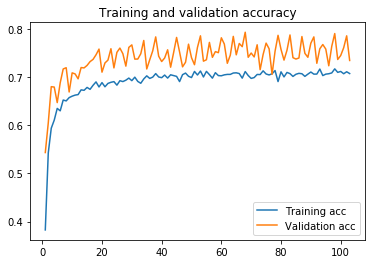

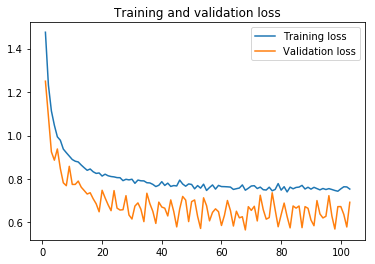

In [9]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

[[ 32   9   5   4   0]
 [ 18  64  10   3   0]
 [  2   1  43   1   0]
 [ 26  15  13 210   3]
 [  2   0   5   0  72]]
Classification Report
                        precision    recall  f1-score   support

          Early_blight       0.40      0.64      0.49        50
           Late_blight       0.72      0.67      0.70        95
             Leaf_Mold       0.57      0.91      0.70        47
Yellow_Leaf_Curl_Virus       0.96      0.79      0.87       267
               healthy       0.96      0.91      0.94        79

             micro avg       0.78      0.78      0.78       538
             macro avg       0.72      0.79      0.74       538
          weighted avg       0.83      0.78      0.80       538



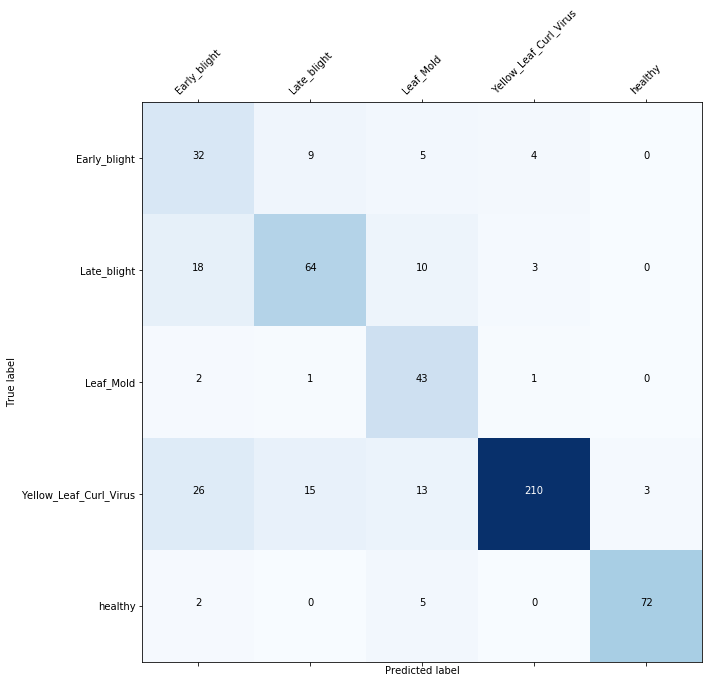

In [10]:
#num_of_test_samples = 2719 
#Y_pred = model.predict_generator(validation_generator, num_of_test_samples // 32+1)
#y_pred = np.argmax(Y_pred, axis=1)
#print('Confusion Matrix')
#print(confusion_matrix(validation_generator.classes, y_pred))

test_generator.reset()
names, index = getTargetNames(test_generator)
num_of_test_samples = 538#674#1072 #1619
steps=np.ceil(num_of_test_samples//32)+1
Y_pred = model.predict_generator(test_generator,steps=steps)
y_pred = np.argmax(Y_pred, axis=1)
#print('Confusion Matrix')
confusion = confusion_matrix(test_generator.classes, y_pred, index)
print(confusion)

classes = range(5)

# create confusion matrix
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion)
cmap=plt.cm.Blues
plt.imshow(confusion, interpolation='nearest', cmap=cmap)
#plt.title('confusion matrix')
#plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, names, rotation=45)
plt.yticks(tick_marks, names)
#plt.yticks(tick_marks, names)

thresh = confusion.max()/2
for i, j in itertools.product(range(confusion.shape[0]), range(confusion.shape[1])):
    plt.text(j, i, confusion[i, j], horizontalalignment='center', color='white' if confusion[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=names))